# **Preparación del entorno**

In [1]:
# Instalar XGBoost
!pip install xgboost --quiet

## **Montar drive en Colab**

In [2]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Configurar conexión con el servidor MLflow**

### Instalar dependencias

In [3]:
# Instalar mlflow y pyngrok
!pip install mlflow pyngrok --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.9/722.9 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.9/194.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

### Configurar pyngrok con token secreto

In [4]:
from google.colab import userdata
from pyngrok import conf

# Leer token desde secreto
ngrok_token = userdata.get("ngrok_token-fv")

# Configurar pyngrok con el token leído
conf.get_default().auth_token = ngrok_token

print("✅ ngrok configurado con secreto en Colab.")

✅ ngrok configurado con secreto en Colab.


### Configurar MLFlow para guardar modelos en drive

In [5]:
# Configurar el directorio de MLflow para que se guarde en Drive
import os
os.environ['MLFLOW_TRACKING_URI'] = "/content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/balance_hidrico/model/mlflow_tracking"

### Lanzar MLFlow

In [23]:
# 1. Matar túneles anteriores
from pyngrok import ngrok
ngrok.kill()

# 2. Importar librerías necesarias
import subprocess
import mlflow

# 3. Establecer tracking URI para los registros desde código (útil para registrar experimentos)
mlflow.set_tracking_uri("file:///content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/balance_hidrico/model/mlflow_tracking")

# 4. Lanzar MLflow UI con la misma URI (para que use la misma carpeta de seguimiento)
mlflow_process = subprocess.Popen([
    "mlflow", "ui",
    "--port", "9090",
    "--backend-store-uri", "file:///content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/balance_hidrico/model/mlflow_tracking"
])

# 5. Exponer UI con ngrok
mlflow_tunnel = ngrok.connect(9090, "http")
print("🌐 MLflow UI disponible en:", mlflow_tunnel.public_url)

🌐 MLflow UI disponible en: https://6b99-34-138-224-186.ngrok-free.app


## **Cargar y explorar el dataset de era5 para entrenar el modelo**

In [7]:
import pandas as pd
import numpy as np

# Leer el archivo csv
df= pd.read_csv("/content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/balance_hidrico/data/era5/Carchi/df_balanceH_historico.csv")

# Convertir la fecha y ordenar
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Extraer año y mes
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Desmostración básica
print(df.head())
print(df.columns)

        date  PET_mm_day  year  month  PET_mm_month  precip_mm     temp_c  \
0 1981-01-01    0.298927  1981      1      9.266738   5.535182  17.696093   
1 1981-02-01    0.191118  1981      2      5.351302  16.218946  17.690462   
2 1981-03-01    0.146592  1981      3      4.544342  10.568353  17.851267   
3 1981-04-01    0.185245  1981      4      5.557337   9.812925  18.065377   
4 1981-05-01    0.247093  1981      5      7.659879   3.734267  17.925042   

     wind_u    wind_v  solar_rad  balance_mm  
0  0.409728  0.060775  15.398627   -3.731556  
1  0.133103  0.007836  14.174679   10.867644  
2  0.232666 -0.041697  14.165354    6.024011  
3  0.164920  0.071957  15.215106    4.255588  
4  0.004642  0.165755  15.256509   -3.925612  
Index(['date', 'PET_mm_day', 'year', 'month', 'PET_mm_month', 'precip_mm',
       'temp_c', 'wind_u', 'wind_v', 'solar_rad', 'balance_mm'],
      dtype='object')


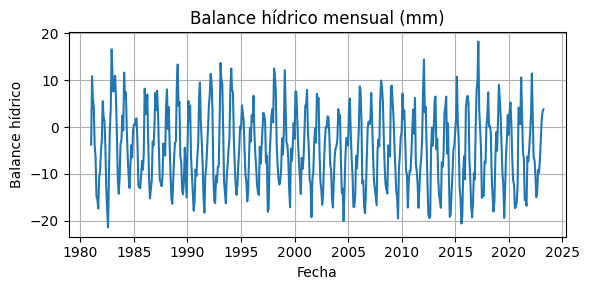

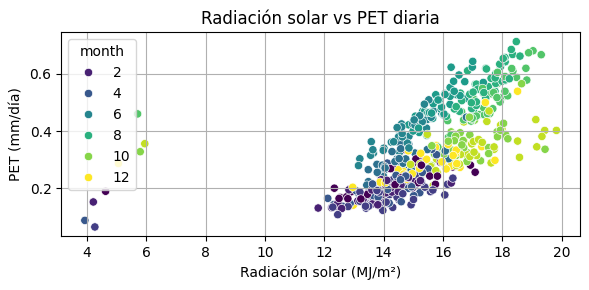

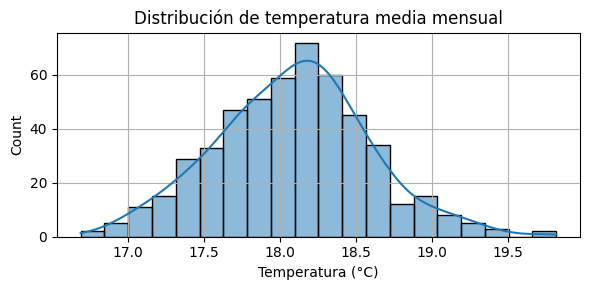

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
import numpy as np

# Activar Bokeh en Colab o Jupyter
output_notebook()

# === GRAFICOS SEABORN (ESTATICOS) ===

# 1. Serie temporal de balance hídrico
plt.figure(figsize=(6, 3))
sns.lineplot(x='date', y='balance_mm', data=df)
plt.title('Balance hídrico mensual (mm)')
plt.xlabel('Fecha')
plt.ylabel('Balance hídrico')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Diagrama de dispersión: solar_rad vs PET_mm_day
plt.figure(figsize=(6, 3))
sns.scatterplot(x='solar_rad', y='PET_mm_day', hue='month', palette='viridis', data=df)
plt.title('Radiación solar vs PET diaria')
plt.xlabel('Radiación solar (MJ/m²)')
plt.ylabel('PET (mm/día)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Histograma de temperatura
plt.figure(figsize=(6, 3))
sns.histplot(df['temp_c'], kde=True, bins=20)
plt.title('Distribución de temperatura media mensual')
plt.xlabel('Temperatura (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

# === GRAFICOS BOKEH (INTERACTIVOS) ===

# Fuente de datos para Bokeh
source = ColumnDataSource(df)

# 4. Línea interactiva: PET mensual
p1 = figure(title="Evapotranspiración mensual (PET)", x_axis_type='datetime', width=700, height=250)
p1.line('date', 'PET_mm_month', source=source, line_width=2, color='green', legend_label="PET mensual")
p1.yaxis.axis_label = 'PET (mm)'
p1.xaxis.axis_label = 'Fecha'
p1.legend.location = 'top_left'

# 5. Dispersión interactiva: precipitación vs PET mensual
p2 = figure(title="Precipitación vs PET mensual", width=700, height=300)
p2.circle('PET_mm_month', 'precip_mm', source=source, size=7, color='blue', alpha=0.6)
p2.xaxis.axis_label = 'PET (mm/mes)'
p2.yaxis.axis_label = 'Precipitación (mm)'

# Mostrar en Colab
show(column(p1, p2))

## **Modelado**

### **División del dataset en datos para entrenamiento y prueba**

- Entrenamiento: hasta 2020
- Prueba: 2021–2023 (para validar capacidad de generalización)
- Normalizar las variables para usar en XGBoost y LSTM.

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Seleccionar características predictoras y variable objetivo
features = ['precip_mm','temp_c', 'wind_u', 'wind_v', 'solar_rad']
target = 'balance_mm'

# Normalizadores
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Filtrar datos por fecha
df_train = df[df['year'] <= 2020]
df_test = df[df['year'] > 2020]

# Aplicar escalado
X_train = scaler_X.fit_transform(df_train[features])
y_train = scaler_y.fit_transform(df_train[[target]])

X_test = scaler_X.transform(df_test[features])
y_test = scaler_y.transform(df_test[[target]])

### **Entrenamiento del Modelo XGBoost**

In [10]:
import mlflow
import mlflow.sklearn
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Asegurar URI y experimento activo
mlflow.set_tracking_uri(mlflow_tunnel.public_url)
mlflow.set_experiment("balance_hidrico_modelo_xgboost")

# Lista de configuraciones de hiperparámetros
param_grid = [
    {"n_estimators": 100, "learning_rate": 0.1},
    {"n_estimators": 200, "learning_rate": 0.1},
    {"n_estimators": 300, "learning_rate": 0.05},
    {"n_estimators": 400, "learning_rate": 0.1}
]

# Entrenamiento y registro por cada configuración
for i, params in enumerate(param_grid):
    with mlflow.start_run(run_name=f"xgboost_v{i+1}"):
        model = XGBRegressor(n_estimators=params["n_estimators"],
                             learning_rate=params["learning_rate"],
                             random_state=42)
        model.fit(X_train, y_train.ravel())

        # Predicción y desescalado
        y_pred_scaled = model.predict(X_test)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
        y_test_inv = scaler_y.inverse_transform(y_test)

        # Métricas
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
        mae = mean_absolute_error(y_test_inv, y_pred)
        r2 = r2_score(y_test_inv, y_pred)

        # Registro en MLflow
        mlflow.log_param("n_estimators", params["n_estimators"])
        mlflow.log_param("learning_rate", params["learning_rate"])
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        mlflow.sklearn.log_model(model, "xgboost_model")

        print(f"✅ Versión {i+5} registrada → n_estimators={params['n_estimators']}, learning_rate={params['learning_rate']}")

2025/05/31 00:02:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Versión 5 registrada → n_estimators=100, learning_rate=0.1
🏃 View run xgboost_v1 at: https://2d4b-34-138-224-186.ngrok-free.app/#/experiments/484284282922969109/runs/9c1fa8a47f404644a28db15857e7b2a9
🧪 View experiment at: https://2d4b-34-138-224-186.ngrok-free.app/#/experiments/484284282922969109


2025/05/31 00:02:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Versión 6 registrada → n_estimators=200, learning_rate=0.1
🏃 View run xgboost_v2 at: https://2d4b-34-138-224-186.ngrok-free.app/#/experiments/484284282922969109/runs/4e28446e08634caebcd9ef29729753c9
🧪 View experiment at: https://2d4b-34-138-224-186.ngrok-free.app/#/experiments/484284282922969109


2025/05/31 00:02:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Versión 7 registrada → n_estimators=300, learning_rate=0.05
🏃 View run xgboost_v3 at: https://2d4b-34-138-224-186.ngrok-free.app/#/experiments/484284282922969109/runs/282e65bb43fc4555b4127c5a824b7ca1
🧪 View experiment at: https://2d4b-34-138-224-186.ngrok-free.app/#/experiments/484284282922969109


2025/05/31 00:03:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Versión 8 registrada → n_estimators=400, learning_rate=0.1
🏃 View run xgboost_v4 at: https://2d4b-34-138-224-186.ngrok-free.app/#/experiments/484284282922969109/runs/48a3667041f149979a59bb747b300675
🧪 View experiment at: https://2d4b-34-138-224-186.ngrok-free.app/#/experiments/484284282922969109


### Cargar mejor modelo desde MLFlow con Run ID

In [24]:
import mlflow
import mlflow.sklearn
import mlflow.keras

# Asegurar la conexión al mismo tracking server
mlflow.set_tracking_uri(mlflow_tunnel.public_url)

# Cargar mejor modelo XGBoost desde su ruta en MLflow
xgb_model_uri = "runs:/282e65bb43fc4555b4127c5a824b7ca1/xgboost_model"
xgb_model_best = mlflow.sklearn.load_model(xgb_model_uri)

### Guardar modelo como pkl y scaler

In [ ]:
import joblib
import os

# Definir la carpeta donde se guardará el modelo
output_dir = "/content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/balance_hidrico/model/pkl"
os.makedirs(output_dir, exist_ok=True)

# Guardar como .pkl
pkl_path = os.path.join(output_dir, "modelo_xgboost_v1.pkl")
joblib.dump(xgb_model_best, pkl_path)

print(f"✅ Modelo guardado exitosamente en:\n{pkl_path}")

In [ ]:
# Guardar escaladores
joblib.dump(scaler_X, f"{output_dir}/scaler_X.pkl")
joblib.dump(scaler_y, f"{output_dir}/scaler_y.pkl")

print("✅ Escaladores guardados correctamente en:")
print(output_dir)

### Métricas de evaluación

In [25]:
# -------------------------
# 1. Cargar datos de evaluación
# -------------------------
df_eval = df.copy()
df_eval = df_eval[(df_eval['date'] >= '2021-01-01') & (df_eval['date'] <= '2023-12-31')].reset_index(drop=True)

X_eval = scaler_X.transform(df_eval[features])
y_eval = scaler_y.transform(df_eval[[target]])

# -------------------------
# 2. Predicción con XGBoost
# -------------------------
y_pred_xgb_scaled = xgb_model_best.predict(X_eval)
y_pred_xgb = scaler_y.inverse_transform(y_pred_xgb_scaled.reshape(-1, 1)).flatten()

# -------------------------
# Visualización
# -------------------------
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Legend
from bokeh.layouts import layout
from bokeh.io import output_file

# 1. Agregar columna de predicción al DataFrame
df_eval['y_pred_xgb'] = y_pred_xgb
source = ColumnDataSource(df_eval)

# 2. Crear figura
p = figure(
    title="Comparación de balance hídrico observado vs. modelo XGBoost (2021–2023)",
    x_axis_type='datetime',
    width=800,
    height=350
)

# 3. Dibujar líneas
obs = p.line('date', 'balance_mm', source=source, color='steelblue', line_width=2, legend_label='🔵 Observado')
pred = p.line('date', 'y_pred_xgb', source=source, color='orangered', line_width=2, line_dash='dashed', legend_label='🔴 Predicción XGBoost')

# 4. Configurar ejes
p.xaxis.axis_label = "Fecha"
p.yaxis.axis_label = "Balance hídrico (mm)"
p.legend.location = "top_left"
p.legend.click_policy = "hide"
p.grid.grid_line_alpha = 0.3

# 5. Mostrar
output_file("/tmp/prediccion_vs_observado.html")
show(p)

## **Proyección del balance hídrico 2024–2050**

### **Cargar dataset SQL desde Supabase**

In [26]:
import requests
import pandas as pd
from google.colab import userdata

# 1. Leer secretos
url = userdata.get("SUPABASE_URL")
api_key = userdata.get("SUPABASE_API_KEY")

# 2. Endpoint para la tabla
endpoint = f"{url}/rest/v1/balance_proyectado"

# 3. Headers de autenticación
headers = {
    "apikey": api_key,
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

# 4. Hacer la consulta GET
response = requests.get(endpoint, headers=headers, params={"select": "*"})

# 5. Convertir a DataFrame
if response.status_code == 200:
    data = response.json()
    df_cmip6 = pd.DataFrame(data)
    print("✅ Datos cargados correctamente desde Supabase vía REST.")
    display(df_cmip6.head())
else:
    print(f"❌ Error {response.status_code}: {response.text}")

✅ Datos cargados correctamente desde Supabase vía REST.


,date,year,month,temp_c,precip_mm,wind_u,wind_v,solar_rad
0,2015-01-16,2015,1,291.42383,0.000109,-9.422890,0.641277,195.43780
1,2015-02-15,2015,2,291.43580,0.000185,-7.968413,0.566743,193.97343
2,2015-03-16,2015,3,291.30470,0.000312,-4.723524,0.570539,151.70688
3,2015-04-16,2015,4,291.40576,0.000331,-2.849622,0.169271,150.48532
4,2015-05-16,2015,5,290.71920,0.000273,-1.718866,0.157390,154.81372


**Transformar las unidades de las variables climáticas del dataset**

In [28]:
df_cmip6['date'] = pd.to_datetime(df_cmip6['date'])
df_cmip6['temp_c'] = df_cmip6['temp_c'] - 273.15  # Kelvin a °C
df_cmip6['precip_mm'] = df_cmip6['precip_mm'] * 86400 * df_cmip6['date'].dt.days_in_month  # kg/m²/s a mm/mes
df_cmip6['solar_rad'] = df_cmip6['solar_rad'] * 3600 * 24 * df_cmip6['date'].dt.days_in_month / 1e6  # W/m² a MJ/m²

### **Predicciones con XGBOOST**

In [29]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource
from bokeh.models.tickers import DatetimeTicker
import pandas as pd

# Paso 1: Asegurar formato datetime en fechas
df_cmip6['date'] = pd.to_datetime(df_cmip6['date'])

# Paso 2: Preparar entradas
df_input = df_cmip6.copy()
X_new = scaler_X.transform(df_input[['precip_mm', 'temp_c', 'wind_u', 'wind_v', 'solar_rad']])

# Paso 3: Predicción con modelo XGBoost cargado desde MLflow
y_pred_xgb_new_scaled = xgb_model_best.predict(X_new)
y_pred_xgb_new = scaler_y.inverse_transform(y_pred_xgb_new_scaled.reshape(-1, 1))

# Paso 4: Agregar resultados al DataFrame
df_input['balance_pred_xgb'] = y_pred_xgb_new
source = ColumnDataSource(df_input)

# Paso 5: Visualizar con Bokeh
p = figure(
    title="Proyección del balance hídrico con XGBoost (2025–2050)",
    x_axis_type='datetime',
    width=900,
    height=400
)

p.line('date', 'balance_pred_xgb', source=source, line_width=2, color='green', legend_label='Predicción XGBoost')

p.xaxis.axis_label = "Año"
p.yaxis.axis_label = "Balance hídrico estimado (mm)"
p.grid.grid_line_alpha = 0.3
p.legend.location = "top_left"

output_file("/tmp/proyeccion_balance_hidrico.html")
show(p)